In [ ]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt 
import tqdm

In [ ]:
from google.colab import drive
drive.mount("content/")

Mounted at content/


In [ ]:
dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def evaluate(model, test_dl, crit):
  tot_loss = 0
  model.eval()
  for x, _ in test_dl:
    x = x.to(dev)
    o = model(x)
    l = crit(o,x)
    tot_loss += l.item()
  test_loss = tot_loss / len(test_dl)
  return test_loss

def train_one_epoch(model, train_dl, crit, optim):
  tot_loss = 0
  model.train()
  for x, _ in train_dl:
    optim.zero_grad()
    x = x.to(dev)
    o = model(x)
    l = crit(o,x)
    l.backward()
    optim.step()
    tot_loss += l.item()
  train_loss = tot_loss / len(train_dl)
  return train_loss

def train(model, train_dl, test_dl, crit, optim, lr_sched=None, epochs=10):
  for epoch in tqdm.tqdm_notebook(range(epochs)):
    train_loss = train_one_epoch(model, train_dl, crit, optim)
    test_loss = evaluate(model, test_dl, crit)
    if lr_sched is not None:
      lr_sched.step()
    print(f"epoch: {epoch}, train loss: {train_loss}, test loss: {test_loss}")

In [ ]:
def make_simple_conv_block(in_planes, out_planes, kernel_size=3):
  return nn.Sequential(
      nn.Conv2d(in_planes, out_planes, kernel_size, bias=False),
      nn.BatchNorm2d(out_planes),
      nn.ReLU(inplace=True)
  )

def make_simple_deconv_block(in_planes, out_planes, kernel_size=3):
  return nn.Sequential(
      nn.ConvTranspose2d(in_planes, out_planes, kernel_size=4,stride=2,padding=1, bias=False),
      nn.BatchNorm2d(out_planes),
      nn.ReLU(inplace=True)
  )

In [ ]:
class Reshape(nn.Module):
  def __init__(self,new_shape):
    super().__init__()
    self.new_shape = new_shape
  
  def forward(self, x):
    return x.view(self.new_shape)

In [ ]:
train_ds = torchvision.datasets.MNIST("./content/MyDrive/MachineLearning/datasets/",train=True,transform=torchvision.transforms.ToTensor())
test_ds = torchvision.datasets.MNIST("./content/MyDrive/MachineLearning/datasets/",train=False,transform=torchvision.transforms.ToTensor())

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=128)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=128)

In [ ]:
class Autoencoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder =  nn.Sequential(
        make_simple_conv_block(1,16),
        make_simple_conv_block(16,16),
        nn.MaxPool2d(2),
        make_simple_conv_block(16,32),
        make_simple_conv_block(32,32),
        nn.MaxPool2d(2),
        make_simple_conv_block(32,64),
        nn.MaxPool2d(2),
        nn.Flatten()
    )

    self.decoder = nn.Sequential(
        nn.Linear(64,128),
        nn.ReLU(inplace=True),
        nn.Linear(128,8*7*7),
        Reshape((-1,8,7,7)),
        make_simple_deconv_block(8,32),
        make_simple_deconv_block(32,1)
    )

  def forward(self,x):
    o = self.encoder(x)
    return self.decoder(o)

In [ ]:
model = Autoencoder().to(dev)

In [ ]:
crit = nn.MSELoss()
optim = torch.optim.SGD(model.parameters(), lr=0.1)
lr_sched = torch.optim.lr_scheduler.StepLR(optim, step_size=5,gamma=0.2)
train(model, train_dl, test_dl, crit, optim, lr_sched=lr_sched, epochs=15)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/15 [00:00<?, ?it/s]

epoch: 0, train loss: 0.0810449428872259, test loss: 0.06984310870683647
epoch: 1, train loss: 0.06300543366210547, test loss: 0.05650949586607233
epoch: 2, train loss: 0.05270285244340073, test loss: 0.04783853610293775
epoch: 3, train loss: 0.04360292933738308, test loss: 0.03716542656663098
epoch: 4, train loss: 0.03464030845761935, test loss: 0.031278302751575844
epoch: 5, train loss: 0.03200204365416122, test loss: 0.030124854508645927
epoch: 6, train loss: 0.031424562627477434, test loss: 0.02959352059737791
epoch: 7, train loss: 0.030920871257432488, test loss: 0.029103330890589123
epoch: 8, train loss: 0.030450732314160893, test loss: 0.02864322872667373
epoch: 9, train loss: 0.030008779659962605, test loss: 0.02821036796026592
epoch: 10, train loss: 0.029760669758007216, test loss: 0.02845242301214345
epoch: 11, train loss: 0.029662966775868747, test loss: 0.028376155898352212
epoch: 12, train loss: 0.02958049695057147, test loss: 0.028295574356106263
epoch: 13, train loss: 0.

In [ ]:
torch.save(model.state_dict(),"./content/MyDrive/MachineLearning/models/mnist_autoencoder.ckpt")

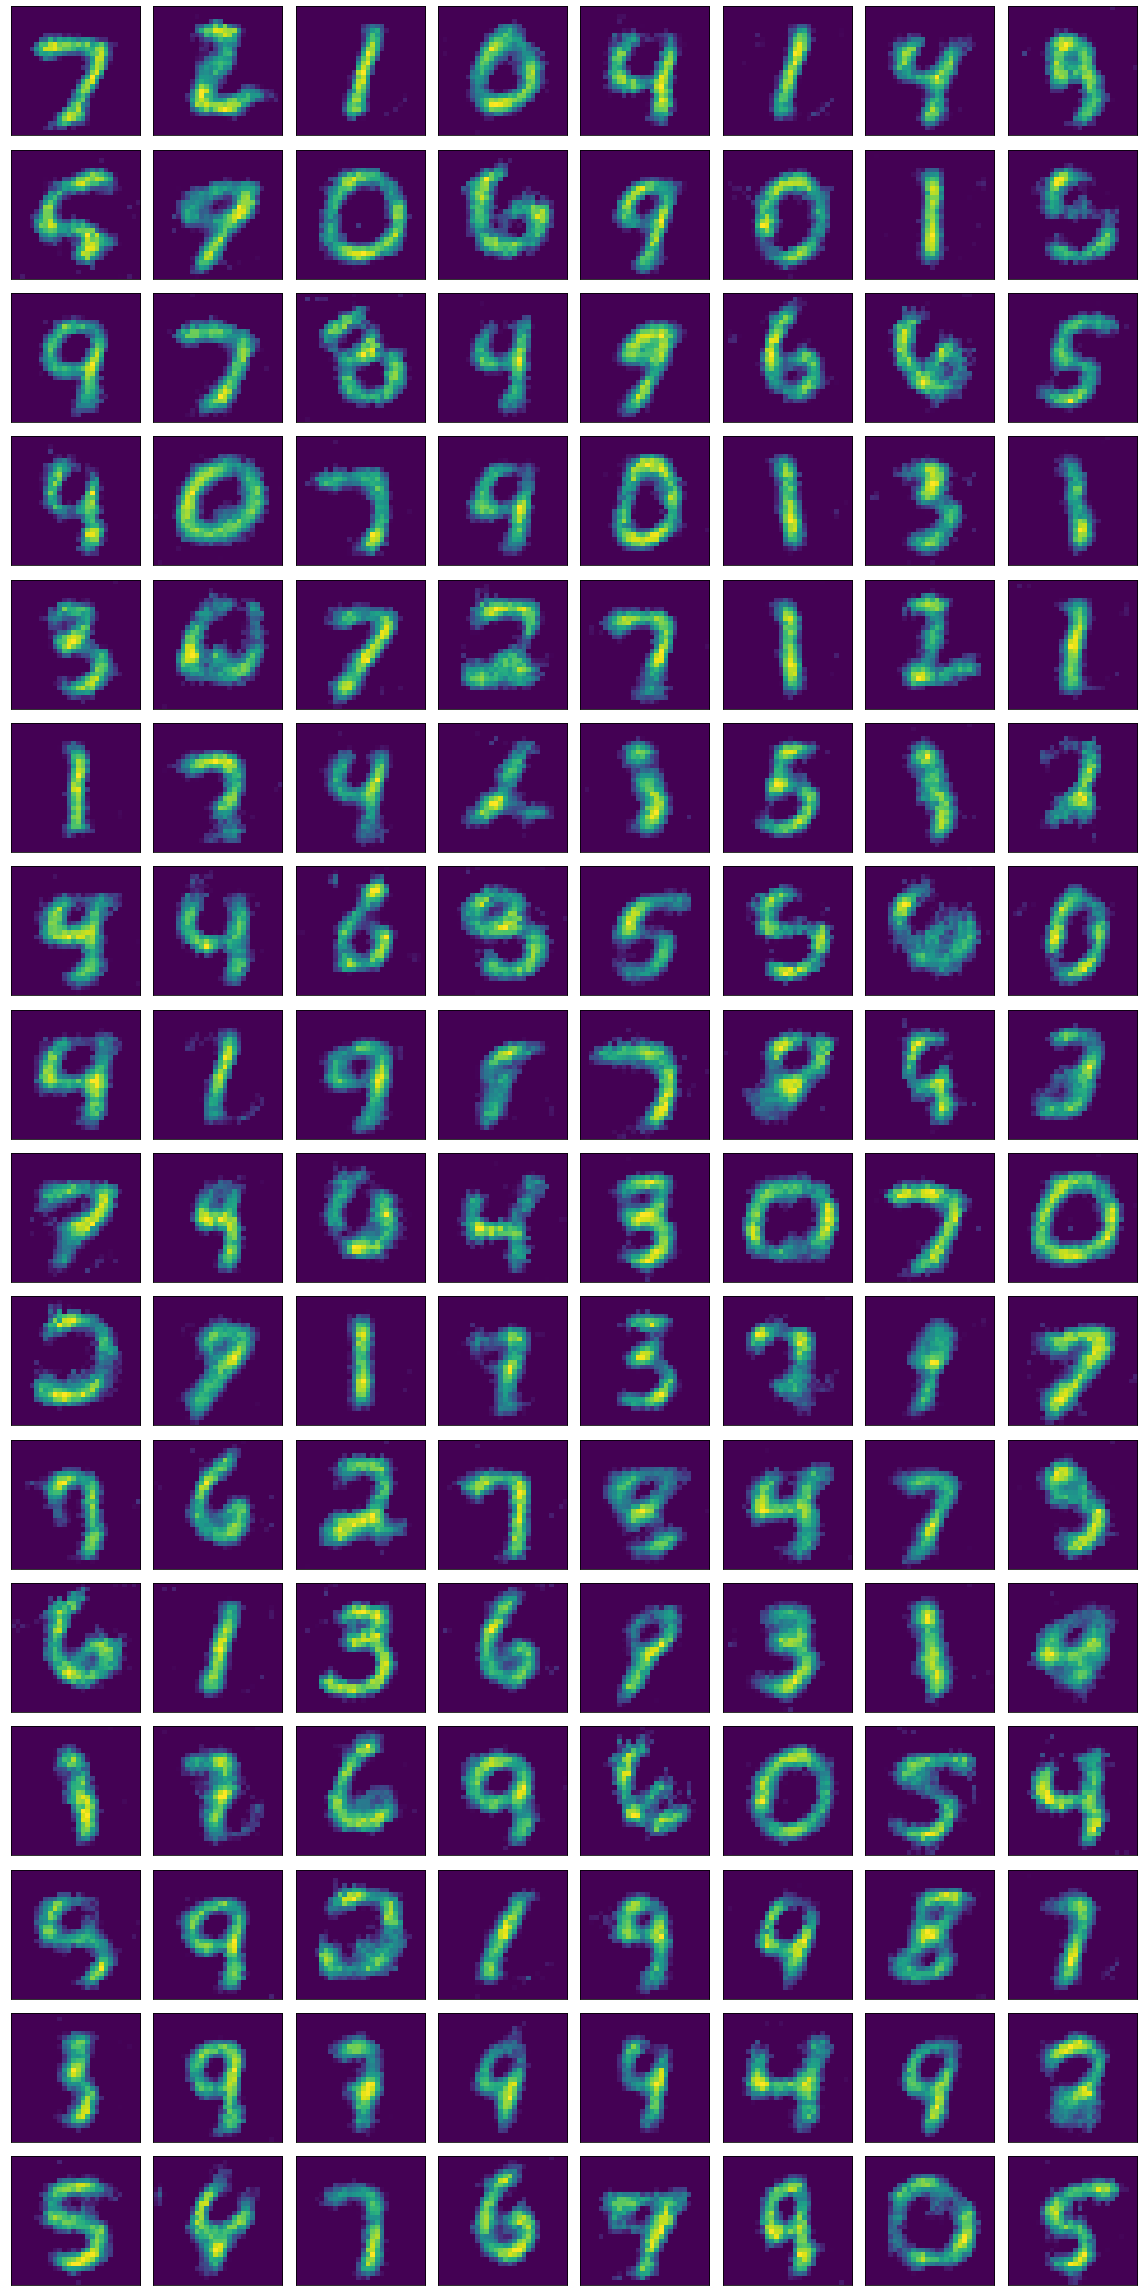

In [ ]:
model.eval()
with torch.no_grad():
  for x, _ in test_dl:
    x = x.to(dev)
    o = model(x).cpu().detach().numpy()
    fig ,axs = plt.subplots(16,8,figsize=(16,32))
    for i in range(128):
      axs[i//8,i%8].imshow(o[i][0])
      axs[i//8,i%8].set_xticks([])
      axs[i//8,i%8].set_yticks([])
    break
plt.tight_layout()

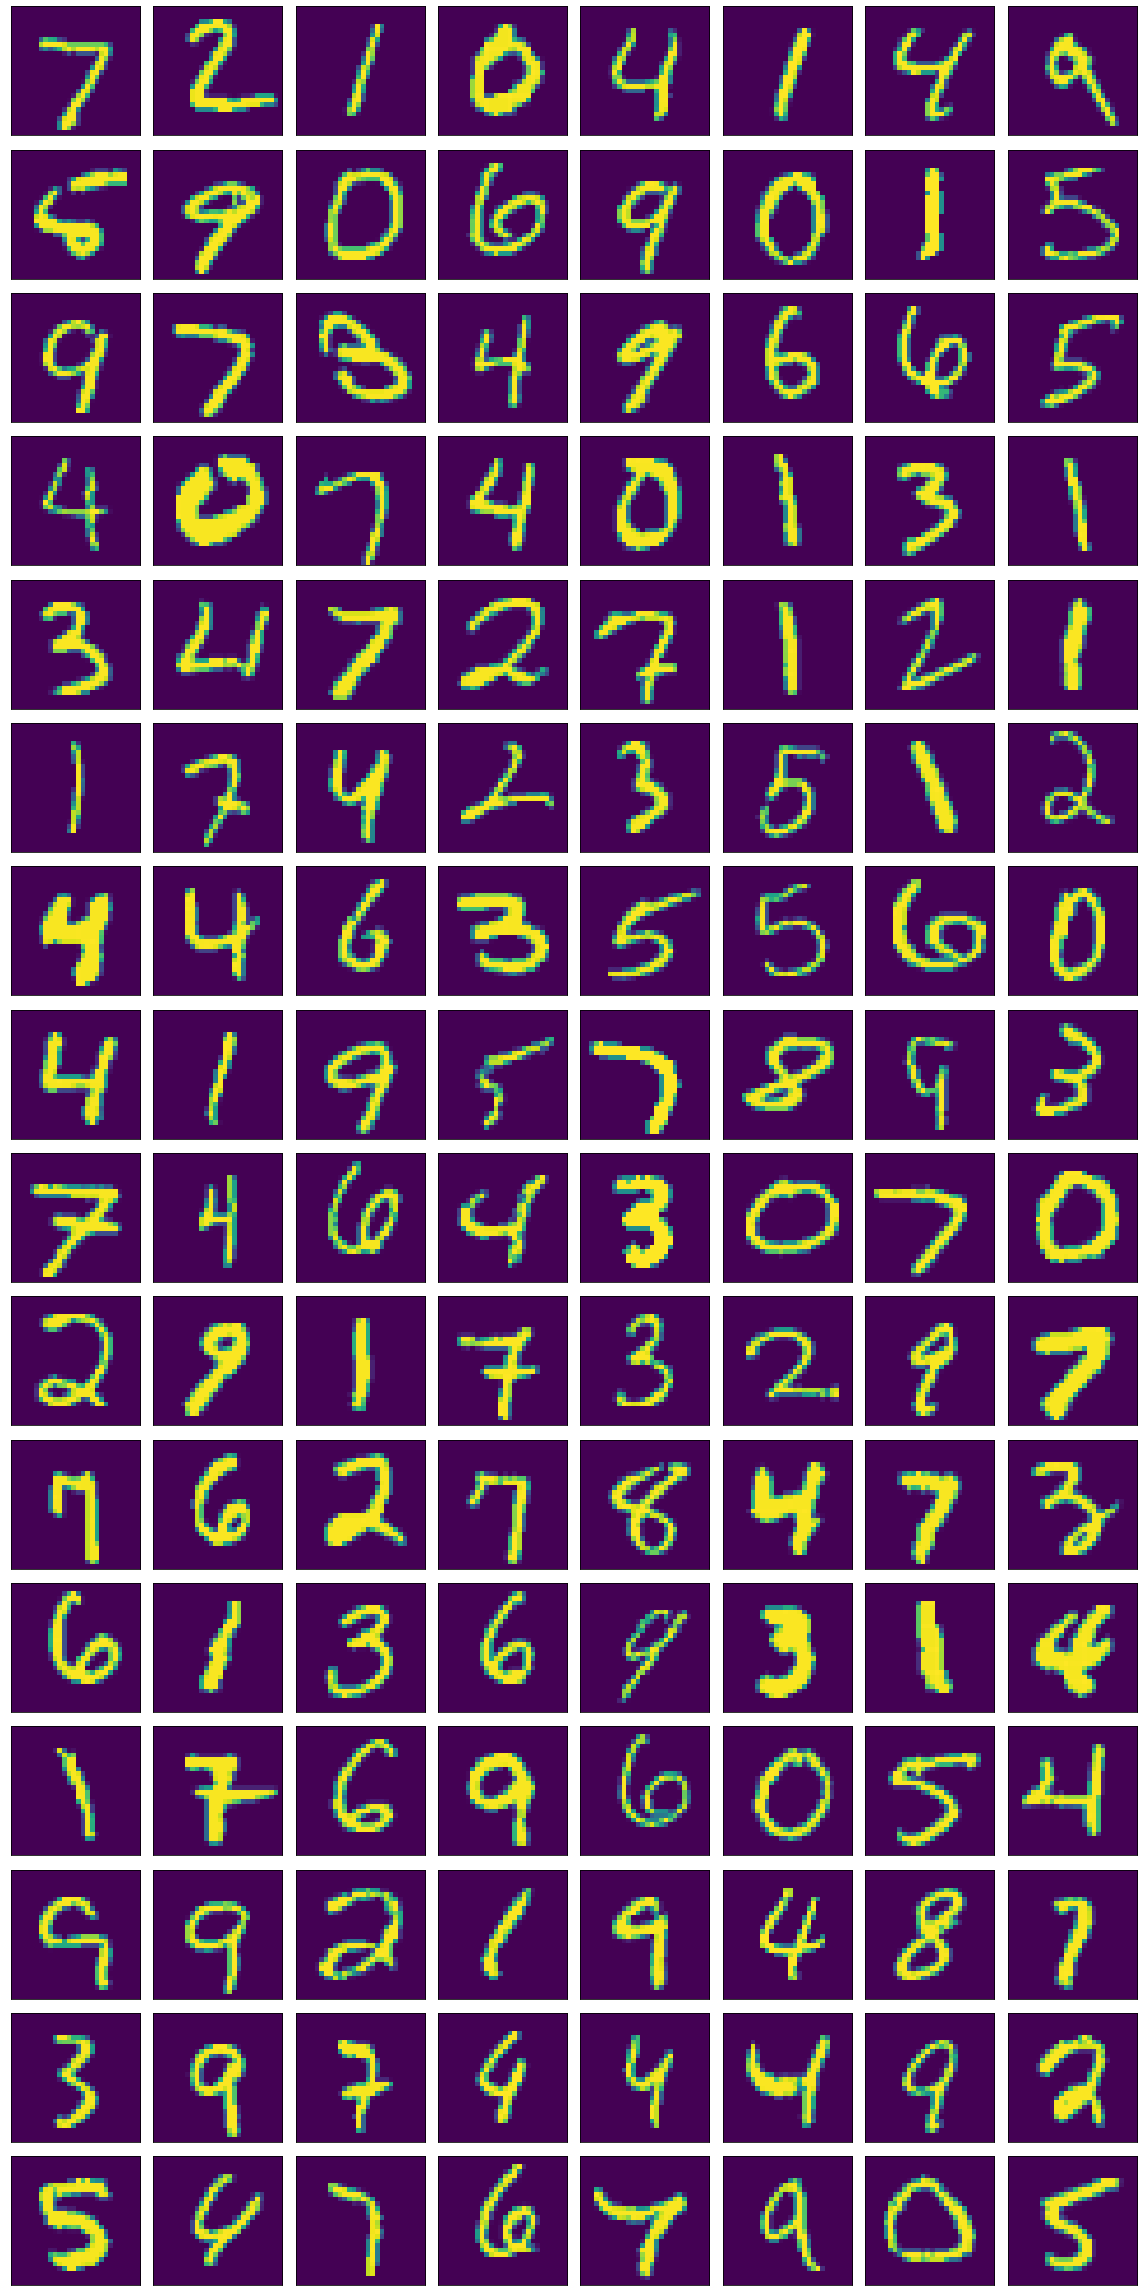

In [ ]:
for x, _ in test_dl:
  fig ,axs = plt.subplots(16,8,figsize=(16,32))
  for i in range(128):
    axs[i//8,i%8].imshow(x[i][0])
    axs[i//8,i%8].set_xticks([])
    axs[i//8,i%8].set_yticks([])
  break
plt.tight_layout()